In [ ]:
import sys
!{sys.executable} -m pip install influxdb

In [101]:
import datetime
import numpy as np
from influxdb import InfluxDBClient
import matplotlib.pyplot as plt

In [102]:
client = InfluxDBClient(host='140.112.42.161', port=23234, database='test_2')

In [103]:
CODE_TO_COUNTRY = {              # country language code to full language name  
        'zh-tw': 'Taiwan',
        'west-eu': 'Europe',
        'west-us': 'West US',
    }

In [104]:
def build_query(t_s, t_e, channel=None, lang=None, loc=None):
    """
    gets all data from month/date to month/(date+1)
    t_s: time start
    t_e: time end 
    lang: stream language
    loc: client location 
    """
    channel = '/.*/' if channel is None else channel
    q = f"SELECT viewer, client_location, ip_list, fq_count, num_edge FROM {channel} WHERE time >= '{t_s}' AND time < '{t_e}'"
    if lang:
        q = f"{q} AND stream_language = '{lang}'"
    if loc:
        q = f"{q} AND client_location = '{loc}'"
    return q

def get_edge_num(result):
    tmp = list()
    transactions = 0
    for (stream, _), points in result.items():
        for point in points:
            edges = point['ip_list'].split(',')
            transactions += sum([int(fq) for fq in point['fq_count'].split(',')])
            for edge in edges:
                if edge not in tmp:
                    tmp.append(edge)
    return set(tmp), transactions

def mean(l):
    return sum(l)/len(l)

def TIMEFMT(t):
    return datetime.datetime.strptime(t, '%Y-%m-%dT%H:%M:%SZ')

#### Task 1: Get all the server IPs found in US in one day

In [97]:
st = f'2019-10-28T00:00:00Z' 
et = f'2019-10-29T00:00:00Z'
q = build_query(st, et, loc='west-us')
result = client.query(q)

In [98]:
print('Data type of the query:', type(result))
print('An item in the query result:\n', result.items()[0])

Data type of the query: <class 'influxdb.resultset.ResultSet'>
An item in the query result:
 (('0nuqtive', None), <generator object ResultSet._get_points_for_series at 0x13283e5f0>)


In [99]:
points = result.items()[0][1]
print(list(points)[:3])
# keys:
#   'time': client request time
#   'viewer': viewer count at the time
#   'client_location'
#   'ip_list': list of server IPs found
#   'fq_count': transaction count
#   'num_edge'

[{'time': '2019-10-28T20:00:38.544032Z', 'viewer': 92.0, 'client_location': 'west-us', 'ip_list': '52.223.228.123', 'fq_count': '12', 'num_edge': 1.0}, {'time': '2019-10-28T20:23:08.562471Z', 'viewer': 76.0, 'client_location': 'west-us', 'ip_list': '52.223.228.123', 'fq_count': '11', 'num_edge': 1.0}]


In [54]:
server_ips, trans_cnt = get_edge_num(result)
print(len(server_ips))
ip_str = str()
for ip in server_ips:
    ip_str += ip + ','
print(ip_str.rstrip(','))

131
52.223.228.4,52.223.247.152,52.223.227.230,52.223.227.248,52.223.247.42,52.223.228.102,52.223.247.96,99.181.96.133,52.223.226.26,52.223.247.120,52.223.228.30,99.181.96.107,52.223.228.68,52.223.228.17,99.181.96.100,99.181.96.165,99.181.96.110,52.223.247.76,99.181.96.125,99.181.96.126,99.181.96.167,52.223.228.27,52.223.247.210,52.223.228.95,52.223.247.169,52.223.247.95,52.223.247.112,52.223.247.170,52.223.227.243,52.223.228.24,52.223.247.165,52.223.228.96,52.223.247.43,52.223.247.178,52.223.228.93,99.181.96.135,52.223.247.233,99.181.96.162,52.223.228.118,52.223.247.130,99.181.96.122,52.223.247.208,52.223.247.150,52.223.247.243,52.223.247.157,52.223.228.18,52.223.247.91,52.223.247.89,52.223.248.243,52.223.247.101,52.223.228.52,52.223.247.111,52.223.247.40,52.223.228.7,52.223.228.89,52.223.247.160,52.223.247.119,52.223.247.229,52.223.228.103,52.223.227.232,52.223.247.63,52.223.228.97,99.181.96.189,52.223.247.135,52.223.247.113,52.223.247.77,52.223.247.211,52.223.228.87,52.223.228.9,99.

#### Task 2: A brief look into the 2019 database

In [60]:
print('Database list:\n', client.get_list_database())

Database list:
 [{'name': '_internal'}, {'name': 'twitchdb'}, {'name': 'test'}, {'name': 'test_1'}, {'name': 'test_2'}, {'name': 'stat_check'}, {'name': 'batch_test'}, {'name': 'test_3'}, {'name': 'test_4'}, {'name': 'test_5'}, {'name': 'test_6'}, {'name': 'test_10'}, {'name': 'test_jason'}, {'name': 'stream_edge_history'}]


In [63]:
st_test = f'2019-10-28T00:00:00Z' 
et_test = f'2019-10-28T00:05:00Z'
test_q = f"SELECT /.*/ FROM /.*/ WHERE time >= '{st_test}' AND time < '{et_test}'"
test_res = client.query(test_q)
test_points = test_res.items()[0][1]
print('DB columns:')
print(list(test_points)[0].keys())

DB columns:
dict_keys(['time', 'client_ip', 'client_location', 'fq_count', 'ip_list', 'num_edge', 'stream_language', 'viewer'])


In [89]:
res1 = client.query('show tag values from /.*/ with key=client_location') 
cli_loc_lst = []
for (stream, _), points in res1.items():
    for point in points:
        cli_loc = point['value']
        if cli_loc not in cli_loc_lst:
            cli_loc_lst.append(cli_loc)
print('client location options:\n', cli_loc_lst)

client location options:
 ['north-eu', 'southeast-asia', 'tw', 'west-eu', 'west-us', 'ko', 'central-au']


In [94]:
res2 = client.query('show tag values from /.*/ with key=stream_language') 
lang_lst = []
for (stream, _), points in res2.items():
    for point in points:
        lang = point['value']
        if lang not in lang_lst:
            lang_lst.append(lang)
print('stream language options:\n', lang_lst)

stream language options:
 ['ko', 'es', 'ja', 'fr', 'ru', 'zh-tw', 'en', 'en-gb', 'es-mx']


#### Task 3: Number of edge servers found in a day

In [105]:
# 2019-10-28 is Monday
date =   ['10-28', '10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']
date_1 = ['10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10', '11-11']

In [137]:
def servers_per_day(d1, d2, loc):
    st = f'2019-{d1}T00:00:00Z'
    et = f'2019-{d2}T00:00:00Z'
    q = build_query(st, et, loc=loc)
    result = client.query(q)
    server_ips, _ = get_edge_num(result)
    return len(server_ips)

In [149]:
d_server_cnt_lst = [[] for i in range(3)]
for curr_d, next_d in zip(date, date_1):
    d_server_cnt_lst[0].append(servers_per_day(curr_d, next_d, 'tw'))
    d_server_cnt_lst[1].append(servers_per_day(curr_d, next_d, 'west-us'))
    d_server_cnt_lst[2].append(servers_per_day(curr_d, next_d, 'west-eu'))

d_server_cnt = {'tw': d_server_cnt_lst[0], 'west-us': d_server_cnt_lst[1], 'west-eu': d_server_cnt_lst[2]}

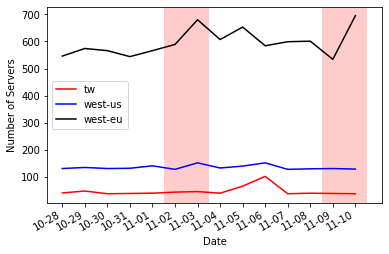

In [158]:
plt.plot(date, d_server_cnt['tw'], 'r', label='tw')
plt.plot(date, d_server_cnt['west-us'], 'b', label='west-us')
plt.plot(date, d_server_cnt['west-eu'], 'k', label='west-eu')
plt.gcf().autofmt_xdate()
plt.legend()

plt.axvspan(4.5, 6.5, facecolor='r', alpha=0.2)
plt.axvspan(11.5, 13.5, facecolor='r', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Number of Servers')

plt.show()

#### Task 4: Number of servers in an hour

In [164]:
hour_1 = [i for i in range(23)]
hour_2 = [i for i in range(1, 24)]
date =   ['10-28', '10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']
date_1 = ['10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10', '11-11']

In [199]:
def servers_per_hour(date_lst, h1, h2, loc):
    servers = []
    for d in date_lst:
        st = f'2019-{d}T{h1:02d}:00:00Z'
        et = f'2019-{d}T{h2:02d}:00:00Z'
        q = build_query(st, et, loc=loc)
        result = client.query(q)
        server_ips, _ = get_edge_num(result)
        servers.append(len(server_ips))
    servers = np.array(servers)
    return np.mean(servers), np.std(servers)

def servers_per_hour_crossday(date_lst, date_1_lst, loc):
    servers = []
    for d1, d2 in zip(date_lst, date_1_lst):
        st = f'2019-{d1}T23:00:00Z'
        et = f'2019-{d2}T00:00:00Z'
        q = build_query(st, et, loc=loc)
        result = client.query(q)
        server_ips, _ = get_edge_num(result)
        servers.append(len(server_ips))
    servers = np.array(servers)
    return np.mean(servers), np.std(servers)

In [200]:
tw_mean_s_lst = []
tw_std_s_lst = []
for h1, h2 in zip(hour_1, hour_2):
    s_mean, s_std = servers_per_hour(date, h1, h2, 'tw')
    tw_mean_s_lst.append(s_mean)
    tw_std_s_lst.append(s_std)

# cross day 23:00 - 0:00
s_mean, s_std = servers_per_hour_crossday(date, date_1, 'tw')
tw_mean_s_lst.append(s_mean)
tw_std_s_lst.append(s_std)

Text(0.5, 1.0, 'Average Servers per Hour in TW')

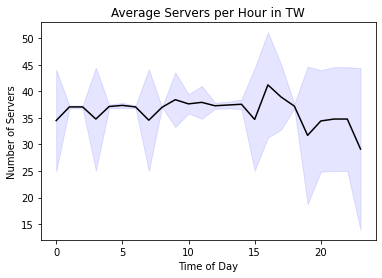

In [211]:
hour = [i for i in range(24)]
tw_mean_s_lst = np.array(tw_mean_s_lst)
tw_std_s_lst = np.array(tw_std_s_lst)

plt.plot(hour, tw_mean_s_lst, 'k')
plt.fill_between(hour, tw_mean_s_lst - tw_std_s_lst, tw_mean_s_lst + tw_std_s_lst, color='b', alpha=0.1)
plt.xlabel('Time of Day')
plt.ylabel('Number of Servers')
plt.title('Average Servers per Hour in TW')

In [203]:
eu_mean_s_lst = []
eu_std_s_lst = []
for h1, h2 in zip(hour_1, hour_2):
    s_mean, s_std = servers_per_hour(date, h1, h2, 'west-eu')
    eu_mean_s_lst.append(s_mean)
    eu_std_s_lst.append(s_std)

# cross day 23:00 - 0:00
s_mean, s_std = servers_per_hour_crossday(date, date_1, 'west-eu')
eu_mean_s_lst.append(s_mean)
eu_std_s_lst.append(s_std)

Text(0.5, 1.0, 'Average Servers per Hour in West-EU')

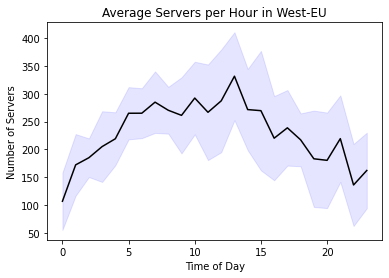

In [212]:
hour = [i for i in range(24)]
eu_mean_s_lst = np.array(eu_mean_s_lst)
eu_std_s_lst = np.array(eu_std_s_lst)

plt.plot(hour, eu_mean_s_lst, 'k')
plt.fill_between(hour, eu_mean_s_lst - eu_std_s_lst, eu_mean_s_lst + eu_std_s_lst, color='b', alpha=0.1)
plt.xlabel('Time of Day')
plt.ylabel('Number of Servers')
plt.title('Average Servers per Hour in West-EU')

In [205]:
us_mean_s_lst = []
us_std_s_lst = []
for h1, h2 in zip(hour_1, hour_2):
    s_mean, s_std = servers_per_hour(date, h1, h2, 'west-us')
    us_mean_s_lst.append(s_mean)
    us_std_s_lst.append(s_std)

# cross day 23:00 - 0:00
s_mean, s_std = servers_per_hour_crossday(date, date_1, 'west-us')
us_mean_s_lst.append(s_mean)
us_std_s_lst.append(s_std)

Text(0.5, 1.0, 'Average Servers per Hour in West-US')

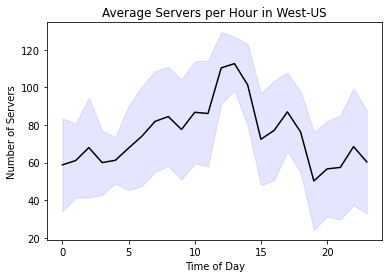

In [213]:
hour = [i for i in range(24)]
us_mean_s_lst = np.array(us_mean_s_lst)
us_std_s_lst = np.array(us_std_s_lst)
plt.plot(hour, us_mean_s_lst, 'k')
plt.fill_between(hour, us_mean_s_lst - us_std_s_lst, us_mean_s_lst + us_std_s_lst, color='b', alpha=0.1)
plt.xlabel('Time of Day')
plt.ylabel('Number of Servers')
plt.title('Average Servers per Hour in West-US')